# Análisis propiedades

## EDA muy preliminar

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
plt.style.use('ggplot')
from sortedcontainers import SortedList
import copy
import collections
from itertools import product,chain
from sklearn.model_selection import KFold

In [42]:
train=pd.read_csv('train.csv',encoding='utf-8')
test=pd.read_csv('test.csv',encoding='utf-8')

In [43]:
train.columns

Index(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'currency', 'price'],
      dtype='object')

In [44]:
test.columns

Index(['Id', 'pais', 'provincia_departamento', 'ciudad', 'property_type',
       'operation_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'currency'],
      dtype='object')

In [45]:
train.head()

Id       pais provincia_departamento        ciudad property_type  \
0   0  Argentina        Capital Federal  Villa Crespo  Departamento   
1   1  Argentina        Capital Federal       Palermo  Departamento   
2   2   Colombia              Atlántico  Barranquilla   Apartamento   
3   3   Colombia        Valle del Cauca          Cali   Apartamento   
4   4  Argentina        Capital Federal     Balvanera  Departamento   

  operation_type  rooms  bedrooms  bathrooms  surface_total currency  \
0          Venta    2.0       1.0        1.0           37.0      USD   
1          Venta    6.0       4.0        4.0          300.0      USD   
2          Venta    3.0       3.0        3.0           95.0      USD   
3          Venta    3.0       3.0        1.0           60.0      USD   
4          Venta    3.0       2.0        1.0           45.0      USD   

       price  
0    85000.0  
1  1590000.0  
2    85329.0  
3    22846.0  
4    80000.0

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25660 entries, 0 to 25659
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      25660 non-null  int64  
 1   pais                    25660 non-null  object 
 2   provincia_departamento  25660 non-null  object 
 3   ciudad                  25660 non-null  object 
 4   property_type           25660 non-null  object 
 5   operation_type          25660 non-null  object 
 6   rooms                   25660 non-null  float64
 7   bedrooms                25660 non-null  float64
 8   bathrooms               25660 non-null  float64
 9   surface_total           25660 non-null  float64
 10  currency                25660 non-null  object 
 11  price                   25660 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.3+ MB


Afortunadamene no tenemos valores nulos.

In [47]:
train.describe()

Id         rooms      bedrooms     bathrooms  surface_total  \
count  25660.00000  25660.000000  25660.000000  25660.000000   25660.000000   
mean   12829.50000      2.648207      1.989751      1.682502      78.966875   
std     7407.54829      1.022895      0.937260      0.895758      53.229903   
min        0.00000      1.000000      1.000000      1.000000      10.000000   
25%     6414.75000      2.000000      1.000000      1.000000      43.000000   
50%    12829.50000      3.000000      2.000000      1.000000      63.000000   
75%    19244.25000      3.000000      3.000000      2.000000      94.000000   
max    25659.00000     12.000000      7.000000      6.000000     347.000000   

              price  
count  2.566000e+04  
mean   1.656802e+05  
std    2.244543e+05  
min    6.009000e+03  
25%    7.100000e+04  
50%    1.050000e+05  
75%    1.700000e+05  
max    3.450000e+06

¿Qué variables no debiesen ser consideradas?

In [48]:
for col in train.select_dtypes(exclude=['int64','float64']):
    print('************************')
    print('Columna:'+col)
    print(train[col].value_counts())
    print('************************')

************************
Columna:pais
Argentina    16892
Colombia      8768
Name: pais, dtype: int64
************************
************************
Columna:provincia_departamento
Capital Federal                 8998
Cundinamarca                    3376
Buenos Aires Costa Atlántica    1964
Santa Fe                        1919
Valle del Cauca                 1762
Antioquia                       1736
Bs.As. G.B.A. Zona Norte        1510
Atlántico                       1456
Bs.As. G.B.A. Zona Sur           795
Bs.As. G.B.A. Zona Oeste         657
Córdoba                          458
Neuquén                          183
Buenos Aires Interior            175
Risaralda                        151
Río Negro                        104
Santander                        102
Mendoza                           74
Bolívar                           43
Quindío                           41
Magdalena                         33
Norte de Santander                33
Tolima                            19
Entr

Vamos a excluir las columnas ```operation_type``` ya que siempre hay una venta, ```property_type``` pues se usan _Departamento_ y _Apartamento_ en cada país y ```currency``` que no aportan valor.

In [49]:
train=train.drop(columns=['operation_type','property_type','currency'])
test=test.drop(columns=['operation_type','property_type','currency'])

In [50]:
train.columns

Index(['Id', 'pais', 'provincia_departamento', 'ciudad', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'price'],
      dtype='object')

In [51]:
cols_plot=train.columns[2:]

Vamos a hacer una breve inspección visual de lo que hay como dato.

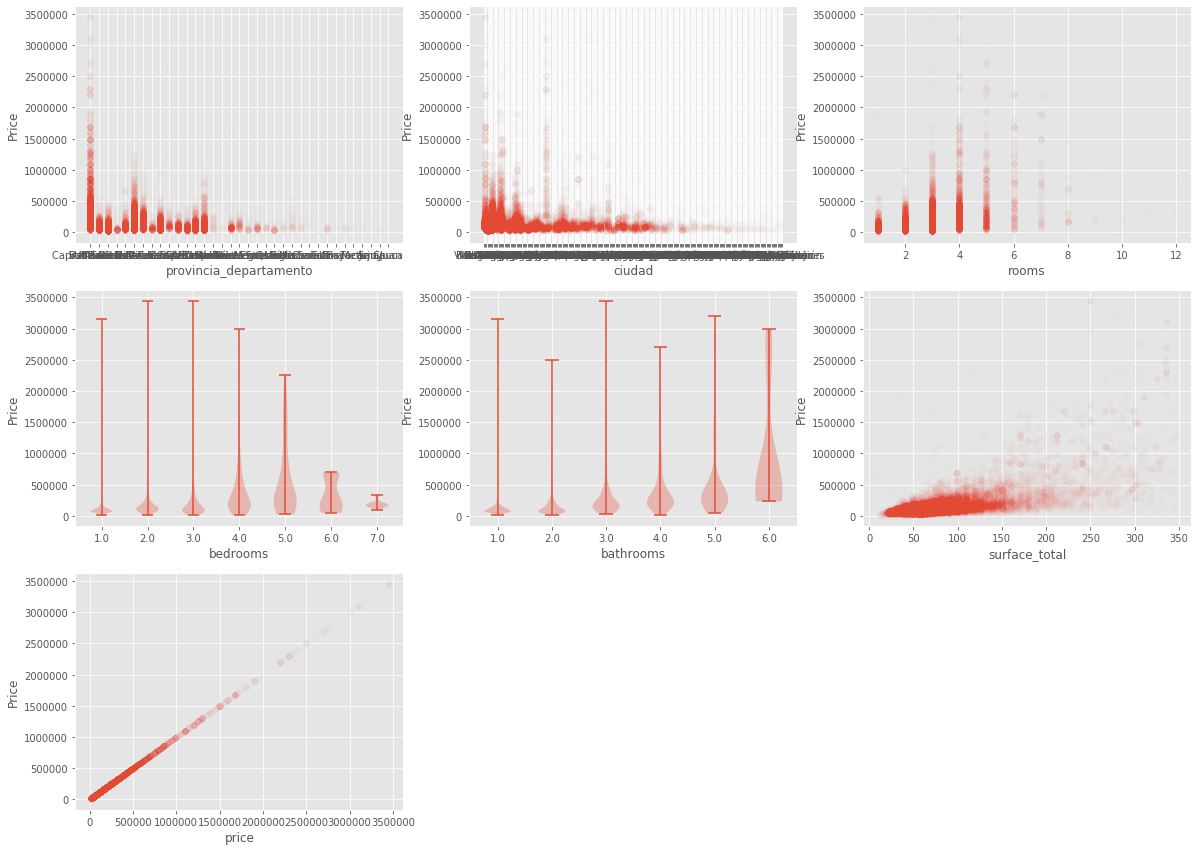

In [52]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(cols_plot):
    plt.subplot(4, 3, i+1)
    col_values = train[feature]
    unique = sorted(set(col_values.dropna().values))
    if len(unique) < 10:
        # categorical: let's make a violin plot
        plt.violinplot([train.price.values[col_values == level] for level in unique],
                       positions=range(len(unique)))
        plt.xticks(range(len(unique)), labels=unique)
    else:
        plt.scatter(col_values.values,train.price.values, alpha=0.01, edgecolor=None)
    plt.xlabel(feature)
    plt.ylabel('Price')
    

Usando los datos tal como están, se daría una oportunidad de mejora

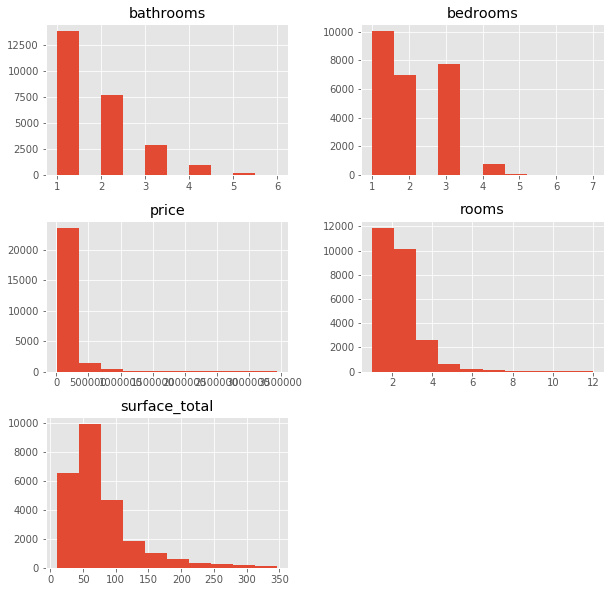

In [53]:
train.iloc[:,1:].hist(figsize=(10,10));

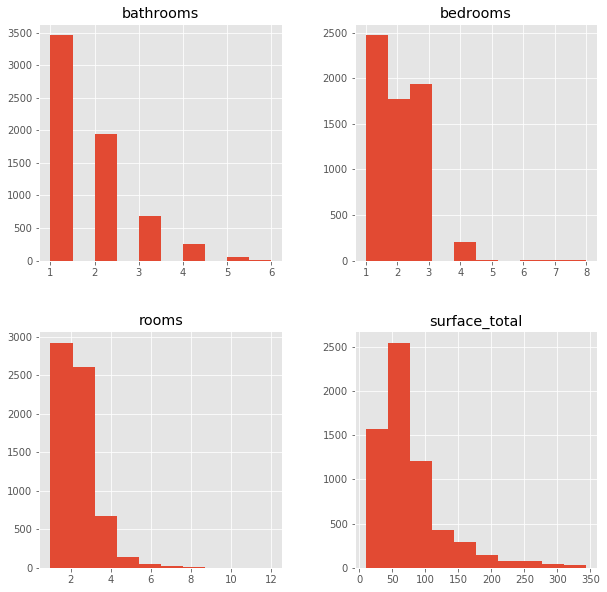

In [54]:
test.iloc[:,1:].hist(figsize=(10,10));

Hay asimetrías en la distribución de varias variables, particularmente fuerte en ```price``` y ```surface_total```. Vamos a verificar si eventualmente conviene filtrar por _outliers_.

In [55]:
def en_rango(serie):
    Q1,Q3=serie.quantile([0.25,0.75])
    IQR=Q3-Q1
    techo=Q3+2.5*IQR
    piso=max(0,Q1-2.5*IQR)
    return (serie<techo) & (serie>piso)

¿Tiene sentido creer que podemos pensar en solo única dinámica de precios para países distintos?

In [56]:
train_arg=train[train.pais=='Argentina']
train_col=train[train.pais=='Colombia']

In [57]:
print("Hay datos de {} ciudades distintas en Argentina".format(len(train_arg.ciudad.unique())))
print("Hay datos de {} ciudades distintas en Colombia".format(len(train_col.ciudad.unique())))

Hay datos de 175 ciudades distintas en Argentina
Hay datos de 75 ciudades distintas en Colombia


El número de categorías para la ciudad no parece muy razonable. Vamos a probar como andaría con Mean Imputing.

In [58]:
def smooth_cat(df,target,feat):
    mean = df[target].mean()
    
    agg = df.groupby(feat)[target].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    
    weight = 100
    smooth = (counts * means + weight * mean)/(counts + weight)
    
    return df[feat].map(smooth)

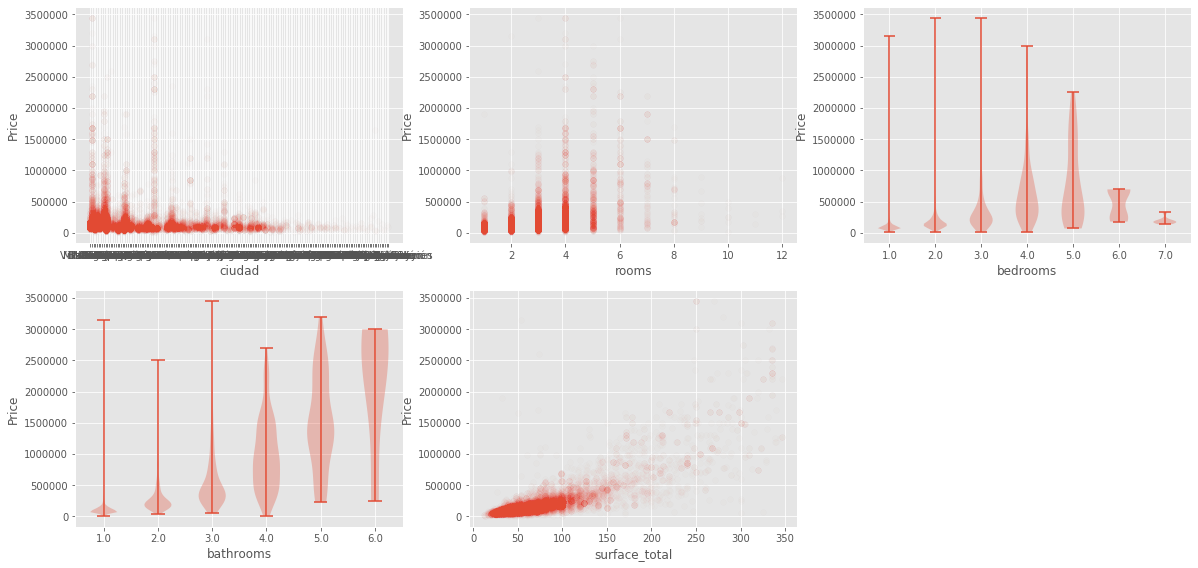

In [59]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(cols_plot[1:-1]):
    plt.subplot(4, 3, i+1)
    col_values = train_arg[feature]
    unique = sorted(set(col_values.dropna().values))
    if len(unique) < 10:
        # categorical: let's make a violin plot
        plt.violinplot([train_arg.price.values[col_values == level] for level in unique],
                       positions=range(len(unique)))
        plt.xticks(range(len(unique)), labels=unique)
    else:
        plt.scatter(col_values.values,train_arg.price.values, alpha=0.01, edgecolor=None)
    plt.xlabel(feature)
    plt.ylabel('Price')

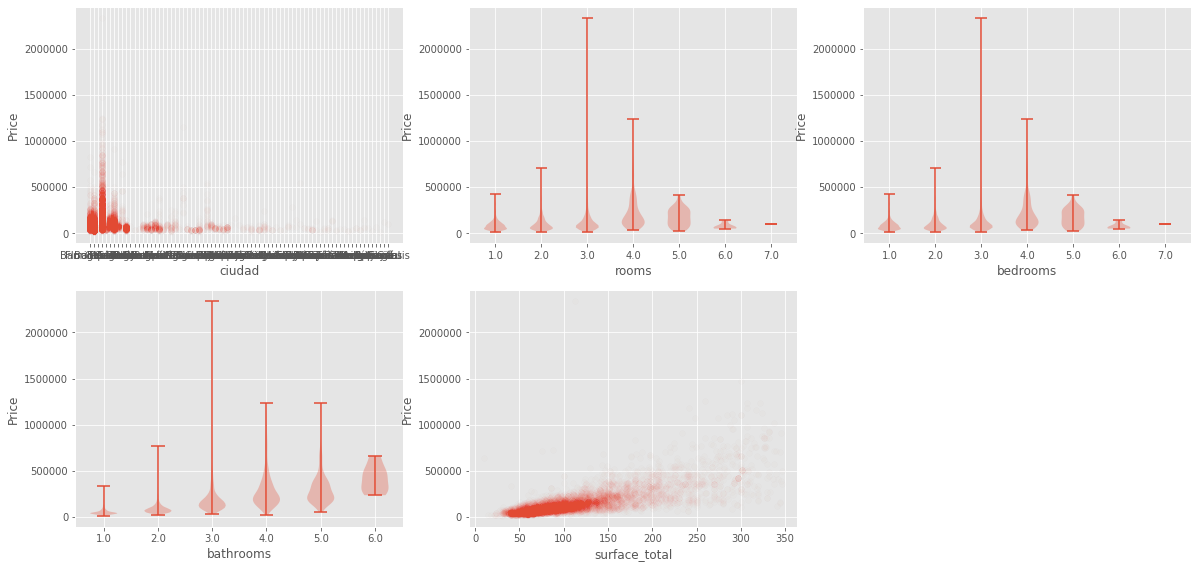

In [60]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(cols_plot[1:-1]):
    plt.subplot(4, 3, i+1)
    col_values = train_col[feature]
    unique = sorted(set(col_values.dropna().values))
    if len(unique) < 10:
        # categorical: let's make a violin plot
        plt.violinplot([train_col.price.values[col_values == level] for level in unique],
                       positions=range(len(unique)))
        plt.xticks(range(len(unique)), labels=unique)
    else:
        plt.scatter(col_values.values,train_col.price.values, alpha=0.01, edgecolor=None)
    plt.xlabel(feature)
    plt.ylabel('Price')

Hay que notar que la variablidad para cada tramo de precio y variable parece ser distinta. Para hacer más fácil la lectura, hare histogramas por país.

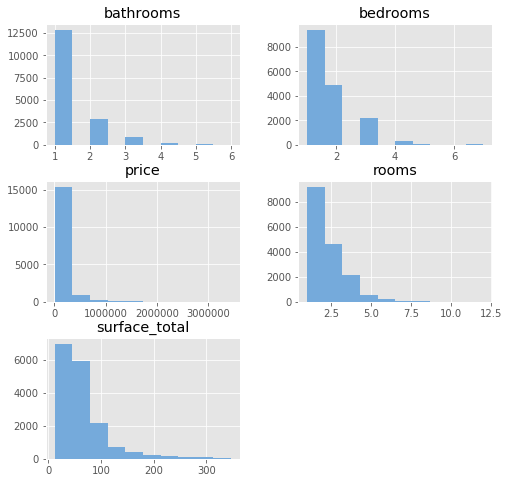

In [61]:
train_arg.iloc[:,2:].hist(figsize=(8,8), color='#75AADB');

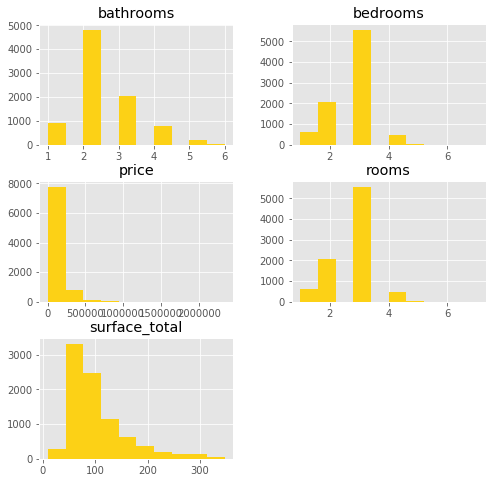

In [62]:
train_col.iloc[:,2:].hist(figsize=(8,8), color='#FCD116');

Dada la fuerte asimetría, Voy a usar la transformación de Box-Cox para ver si hay alguna mejora.

In [63]:
from scipy import stats
trains=[train_arg,train_col]
columnas=['surface_total','price']
#Cambio precio y superficie para cada país
fitted_lambdas=[]

for t in trains:
    for columna in columnas:
        y, fitted_lambda = stats.boxcox(t[columna])
        fitted_lambdas.append(fitted_lambda)
        t[columna]=y

/Users/ggoni/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [64]:
fitted_lambdas

[-0.5866245649980928,
 -0.41576726371403894,
 -0.3674595194695659,
 -0.24687443449365915]

In [65]:
lambda_sur_arg=fitted_lambdas[0]
lambda_price_arg=fitted_lambdas[1]
lambda_sur_col=fitted_lambdas[2]
lambda_price_col=fitted_lambdas[3]

In [71]:
train_arg

Id       pais        provincia_departamento            ciudad  \
0          0  Argentina               Capital Federal      Villa Crespo   
1          1  Argentina               Capital Federal           Palermo   
4          4  Argentina               Capital Federal         Balvanera   
6          6  Argentina        Bs.As. G.B.A. Zona Sur          La Plata   
7          7  Argentina               Capital Federal      Villa Crespo   
...      ...        ...                           ...               ...   
25654  25654  Argentina               Capital Federal          Belgrano   
25656  25656  Argentina               Capital Federal         Caballito   
25657  25657  Argentina               Capital Federal  Villa del Parque   
25658  25658  Argentina               Capital Federal     San Cristobal   
25659  25659  Argentina  Buenos Aires Costa Atlántica     Mar del Plata   

       rooms  bedrooms  bathrooms  surface_total     price  
0        2.0       1.0        1.0       1.499696  2.383730  
1        6.0       4.0        4.0       1.644620  2.398841  
4        3.0       2.0        1.0       1.521932  2.383183  
6        3.0       2.0        1.0       1.580540  2.387699  
7        4.0       3.0        1.0       1.590277  2.389278  
...      ...       ...        ...            ...       ...  
25654    7.0       5.0        4.0       1.644620  2.398685  
25656    2.0       1.0        1.0       1.508859  2.383730  
25657    2.0       1.0        1.0       1.551798  2.389684  
25658    3.0       2.0        1.0       1.538657  2.386597  
25659    2.0       1.0        1.0       1.521932  2.380884  

[16892 rows x 9 columns]

In [66]:
X_train_arg=train_arg.iloc[:,2:-1]
y_train_arg=train_arg.iloc[:,-1]

provincia_departamento            ciudad  rooms  bedrooms  \
0                   Capital Federal      Villa Crespo    2.0       1.0   
1                   Capital Federal           Palermo    6.0       4.0   
4                   Capital Federal         Balvanera    3.0       2.0   
6            Bs.As. G.B.A. Zona Sur          La Plata    3.0       2.0   
7                   Capital Federal      Villa Crespo    4.0       3.0   
...                             ...               ...    ...       ...   
25654               Capital Federal          Belgrano    7.0       5.0   
25656               Capital Federal         Caballito    2.0       1.0   
25657               Capital Federal  Villa del Parque    2.0       1.0   
25658               Capital Federal     San Cristobal    3.0       2.0   
25659  Buenos Aires Costa Atlántica     Mar del Plata    2.0       1.0   

       bathrooms  surface_total  
0            1.0       1.499696  
1            4.0       1.644620  
4            1.0       1.521932  
6            1.0       1.580540  
7            1.0       1.590277  
...          ...            ...  
25654        4.0       1.644620  
25656        1.0       1.508859  
25657        1.0       1.551798  
25658        1.0       1.538657  
25659        1.0       1.521932  

[16892 rows x 6 columns]

In [ ]:
train_col.head()

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
X_train_arg.head()

In [ ]:
cb_arg=CatBoostRegressor()

In [ ]:
cb_arg.fit(X_train_arg,y_train_arg,cat_features=[0,1],silent=True)

In [ ]:
X_train_col=train_col.iloc[:,2:-1]
y_train_col=train_col.iloc[:,-1]

In [ ]:
X_train_col.head()

In [ ]:
cb_col=CatBoostRegressor()

In [ ]:
cb_col.fit(X_train_col,y_train_col,cat_features=[0,1],silent=True)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
y_pred_train_arg=cb_arg.predict(X_train_arg)

In [ ]:
mean_squared_error(y_train_arg,y_pred_train_arg)

In [ ]:
y_train_arg

In [ ]:
y_pred_train_col=cb_col.predict(X_train_col)

In [ ]:
mean_squared_error(y_train_col,y_pred_train_col)

In [ ]:
from scipy.special import boxcox, inv_boxcox

In [ ]:
X_test_arg=test.loc[test.pais=='Argentina']
X_test_arg['surface_total']=boxcox(X_test_arg['surface_total'],lambda_sur_arg)
X_test_arg.drop(columns=['pais'],inplace=True)

In [ ]:
X_test_col=test.loc[test.pais=='Colombia']
X_test_col['surface_total']=boxcox(X_test_col['surface_total'],lambda_sur_col)
X_test_col.drop(columns=['pais'],inplace=True)

In [ ]:
y_pred_test_arg=inv_boxcox(cb_arg.predict(X_test_arg.iloc[:,1:]),lambda_price_arg)

In [ ]:
y_pred_test_col=inv_boxcox(cb_col.predict(X_test_col.iloc[:,1:]),lambda_price_col)

In [ ]:
df_arg=pd.DataFrame(zip(X_test_arg.Id,y_pred_test_arg),columns=['Id','price'])

In [ ]:
df_col=pd.DataFrame(zip(X_test_col.Id,y_pred_test_col),columns=['Id','price'])

In [ ]:
df_arg

In [ ]:
precios=pd.concat([df_arg,df_col],axis=0)

In [ ]:
precios.sort_values(by='Id',inplace=True)

#ra verión del 14 de Julio
precios.to_csv('/Users/ggoni/Desktop/submission.csv',index=False)

## Pendientes

 1. [ ] ¿Valdrá la pena filtrar outliers despues de Box-Cox? 
 2. [ ] ¿Se obtendría mejores resultados haciendo blending de modelos?

In [ ]:
len(en_rango(train_arg.price))-sum(en_rango(train_arg.price))

In [ ]:
len(en_rango(train_col.price))-sum(en_rango(train_col.price))

In [ ]:
train_arg.price.hist()

In [ ]:
cb_arg.save_model('Model_prop_arg.pkl')
cb_col.save_model('Model_prop_col.pkl')

In [ ]:
train_arg.head()

In [ ]:
lambda_price_arg

In [ ]:
lambda_sur_arg

In [ ]:
lambda_price_col

In [ ]:
train.bathrooms.max()

In [ ]:
cb_arg.feature_names_

In [ ]:
cb_arg.predict(['Capital Federal','Palero',6,4,1,1.5])

In [ ]:
import catboost

In [ ]:
cb_arg.save_model('cb_arg')
cb_col.save_model('cb_col')

In [ ]:
cb_arg.feature_importances_

In [ ]:
df_imp=pd.DataFrame(zip(cb_arg.feature_names_,cb_arg.feature_importances_),\
    columns=['Variable','Importancia'])

In [ ]:
df_imp